This notebook pulls the data from the Features.parquet file and is used to validate that we preseve the data accross saves to parquet format. Data should compare with the develop_simple_features.ipynb

In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import polars as pl
import tensorflow as tf
from matplotlib.colors import ListedColormap


from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam, RMSprop

2023-12-05 15:27:35.434998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_path = './sign_data/'

In [3]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path(dataset_path + "data/train_features.parquet")
test_file = Path(dataset_path + "data/test_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path(dataset_path + "data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dft = dft.join(dfm, on="ClassId")

dfe = pl.read_parquet(test_file, memory_map=True)
dfe = dfe.join(dfm, on="ClassId")

# del dfm

In [4]:
dft.head(1)

id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[247, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]",[binary data],"[56, 112, … 0]","[0.318327, 0.160083, … 0.28708]",[binary data],"[0.318798, 0.301229, … 0.194583]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""C:\Users\edbro…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [5]:
samples_per_class = 200
random_seed = 42
train_sampled_df = pl.concat([x.sample(samples_per_class, with_replacement=False, seed=random_seed) for x in dft.partition_by("ClassId")])

In [6]:
train_sampled_df.columns

['id',
 'ClassId',
 'Width',
 'Height',
 'Image',
 'Resolution',
 'Scaled_Meta_Image',
 'Hue_Hist',
 'Saturation_Hist',
 'Value_Hist',
 'LBP_Image',
 'LBP_Hist',
 'HOG_Features',
 'HOG_Image',
 'Template_Pattern',
 'RESNET101',
 'VGG16',
 'Path',
 'ShapeId',
 'ColorId',
 'SignId',
 'Description',
 'Meta_Image',
 'Meta_Width',
 'Meta_Height',
 'Meta_Resolution',
 'Scaled_Meta_Width',
 'Scaled_Meta_Height',
 'Scaled_Meta_Image_right',
 'Scaled_Meta_Resolution']

In [7]:
columns = [
           'ClassId', 'Hue_Hist', 'Saturation_Hist', 'HOG_Features',
           'Template_Pattern', 'LBP_Image'
          ]
features = train_sampled_df[columns]
features.head(1)

ClassId,Hue_Hist,Saturation_Hist,HOG_Features,Template_Pattern,LBP_Image
i64,list[i64],list[i64],list[f32],list[f32],binary
20,"[972, 151, … 16]","[247, 0, … 0]","[0.25923, 0.184951, … 0.0]","[0.245245, 0.24306, … 0.12408]",[binary data]


In [8]:
test_features = dfe[columns]
test_features.head(1)


ClassId,Hue_Hist,Saturation_Hist,HOG_Features,Template_Pattern,LBP_Image
i64,list[i64],list[i64],list[f32],list[f32],binary
16,"[63, 58, … 113]","[0, 0, … 0]","[0.119428, 0.135571, … 0.005196]","[0.097359, 0.076541, … 0.101359]",[binary data]


In [9]:
del dft
del dfe
del dfm


### CNN Model

In [10]:
# ms_input_shape_hog = (X_train.shape[1], 1)
# ms_input_shape_lbp = (X_train_lbp.shape[1], 1)
# ms_input_shape_hue = (X_train_hue.shape[1], 1)
# ms_input_shape_sat = (X_train_sat.shape[1], 1)

# define the model 
def create_cnn_model(padding='same',               
                    input_shape=None):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=21, strides=1, padding=padding, activation='relu', 
                    input_shape= input_shape,kernel_initializer=keras.initializers.he_normal()))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Conv1D(filters=16, kernel_size=5, strides=1, padding=padding,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84))
    model.add(Dropout(rate=0.5, name='Dropout'))
    model.add(Dense(43, activation='softmax', name='Output'))
    return model

# model_hog = create_cnn_model(input_shape=input_shape)
# model_hog.summary()

In [11]:
# Create a confusion matrix as a 2D array.
def plot_confusion_matrix(title, y_test, y_prediction):
    label_names = [f"Class {i}" for i in range(43)]

    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(12, 10))

    color_map1 = ['lightgrey', '#ffff99', 'orange', '#7fc97f']
    color_map = ListedColormap(color_map1)

    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=color_map,
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Count"},
        xticklabels=label_names,
        yticklabels=label_names,
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title + " Confusion Matrix", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=80, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout to prevent cutoff of labels
    plt.tight_layout()

    # Add axis labels.
    # ax.set(xlabel="Predicted Label", ylabel="True Label")
    plt.show()
    return

### HOG Features

In [18]:
# Derive HOG dataset

features_hog = features['HOG_Features'].to_numpy()
features_hog = np.stack(features_hog)

# split the data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(features_hog, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)

# X_train = features['HOG_Features'].to_numpy()
# X_train = np.stack(X_train)
# y_train = features['ClassId'].to_numpy()

# X_test = test_features['HOG_Features'].to_numpy()
# X_test = np.stack(X_test)
# y_test = test_features['ClassId'].to_numpy()


In [19]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (6880, 2916)
y_train.shape: (6880,)
X_test.shape: (1720, 2916)
y_test.shape: (1720,)


In [20]:
model_hog = create_cnn_model(input_shape=(X_train.shape[1], 1))
model_hog.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2916, 6)           132       
                                                                 
 batch_normalization (BatchN  (None, 2916, 6)          24        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1458, 6)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1458, 16)          496       
                                                                 
 batch_normalization_1 (Batc  (None, 1458, 16)         64        
 hNormalization)                                                 
                                                        

In [21]:
model_hog.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['acc'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]

BATCH_SIZE = 32 
EPOCHS = 10

history = model_hog.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
172/172 [==============================] - 9s 47ms/step - loss: 1.9405 - acc: 0.4735 - val_loss: 10.0214 - val_acc: 0.1533
Epoch 2/10
172/172 [==============================] - 8s 48ms/step - loss: 0.5726 - acc: 0.8236 - val_loss: 2.1570 - val_acc: 0.6330
Epoch 3/10
172/172 [==============================] - 8s 49ms/step - loss: 0.2444 - acc: 0.9242 - val_loss: 0.3020 - val_acc: 0.9048
Epoch 4/10
172/172 [==============================] - 8s 49ms/step - loss: 0.1175 - acc: 0.9609 - val_loss: 0.2486 - val_acc: 0.9353
Epoch 5/10
172/172 [==============================] - 9s 49ms/step - loss: 0.1023 - acc: 0.9702 - val_loss: 0.2636 - val_acc: 0.9382
Epoch 6/10
172/172 [==============================] - 9s 52ms/step - loss: 0.0565 - acc: 0.9844 - val_loss: 0.2260 - val_acc: 0.9469
Epoch 7/10
172/172 [==============================] - 9s 51ms/step - loss: 0.0480 - acc: 0.9875 - val_loss: 0.2263 - val_acc: 0.9557
Epoch 8/10
172/172 [==============================] - 9s 50ms/step -

In [22]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_hog.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


Evaluate on test data
54/54 [==============================] - 1s 8ms/step - loss: 0.2535 - acc: 0.9395
test loss, test acc: [0.25353819131851196, 0.9395349025726318]


Predicting ...
54/54 [==============================] - 1s 8ms/step

Accuracy on Test Set: 93.95348837209302


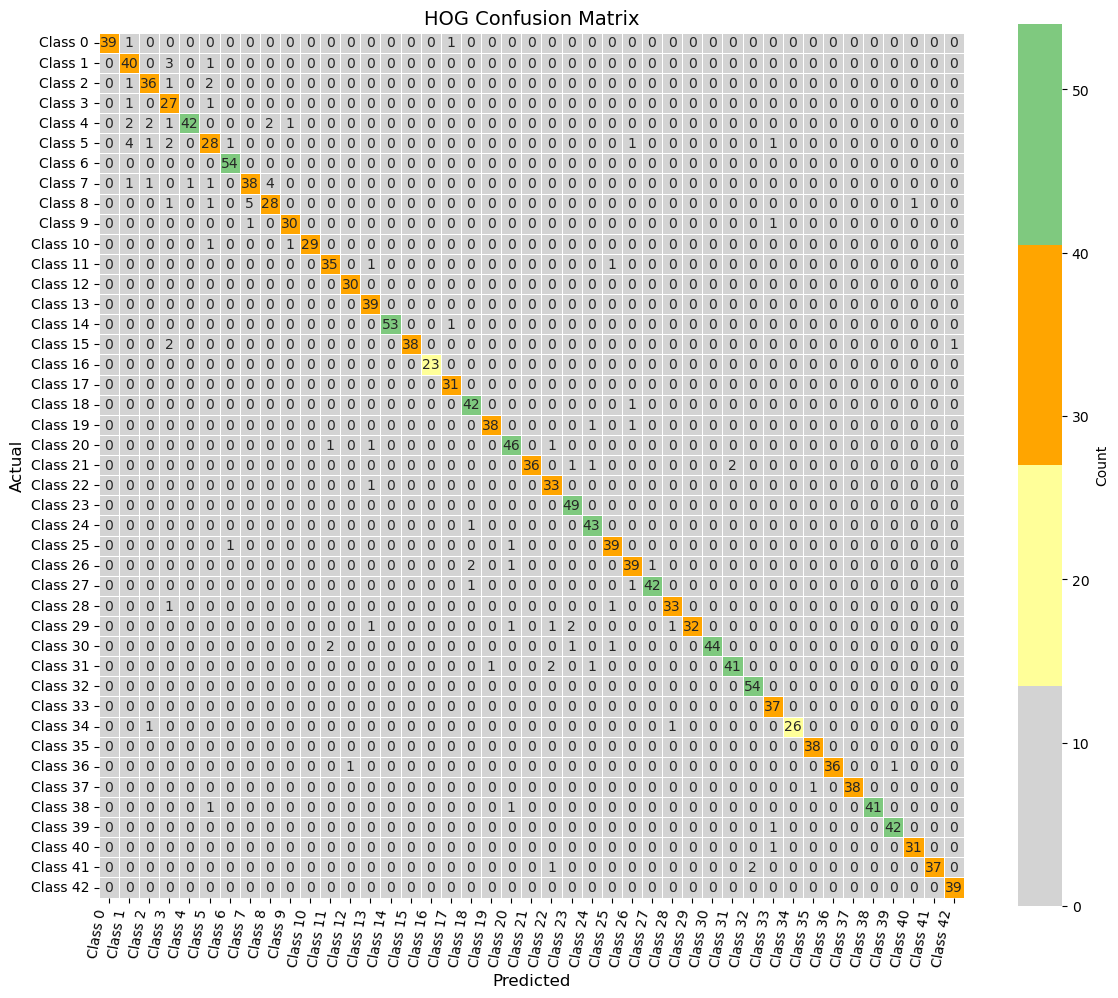

In [23]:
# Predict
print('Predicting ...')
y_pred = model_hog.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

plot_confusion_matrix('HOG', y_test, y_prediction)

<HR>

### Template Features

In [24]:
# Derive Template dataset

features_tem = features['Template_Pattern'].to_numpy()
features_tem = np.stack(features_tem)

# split the data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(features_tem, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)

# X_train = features['Template_Pattern'].to_numpy()
# X_train = np.stack(X_train)
# y_train = features['ClassId'].to_numpy()

# X_test = test_features['Template_Pattern'].to_numpy()
# X_test = np.stack(X_test)
# y_test = test_features['ClassId'].to_numpy()


In [25]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (6880, 3483)
y_train.shape: (6880,)
X_test.shape: (1720, 3483)
y_test.shape: (1720,)


In [26]:
model_tem = create_cnn_model(input_shape=(X_train.shape[1], 1))
# model_tem.summary()

In [32]:
model_tem.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['acc'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]

BATCH_SIZE = 32 
EPOCHS = 20

history = model_tem.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 10s 54ms/step - loss: 0.2131 - acc: 0.9335 - val_loss: 0.7874 - val_acc: 0.8467
Epoch 2/20
172/172 [==============================] - 10s 57ms/step - loss: 0.2024 - acc: 0.9362 - val_loss: 0.9522 - val_acc: 0.8016
Epoch 3/20
172/172 [==============================] - 10s 58ms/step - loss: 0.1881 - acc: 0.9397 - val_loss: 0.7376 - val_acc: 0.8416
Epoch 4/20
172/172 [==============================] - 10s 57ms/step - loss: 0.1671 - acc: 0.9471 - val_loss: 0.8313 - val_acc: 0.8430
Epoch 5/20
172/172 [==============================] - 10s 58ms/step - loss: 0.1420 - acc: 0.9544 - val_loss: 0.9958 - val_acc: 0.8227
Epoch 6/20
172/172 [==============================] - 10s 58ms/step - loss: 0.1620 - acc: 0.9493 - val_loss: 0.9473 - val_acc: 0.8394


In [33]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_tem.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


Evaluate on test data
54/54 [==============================] - 1s 10ms/step - loss: 0.8906 - acc: 0.8331
test loss, test acc: [0.8905701637268066, 0.8331395387649536]


Predicting ...
54/54 [==============================] - 1s 10ms/step

Accuracy on Test Set: 83.31395348837209


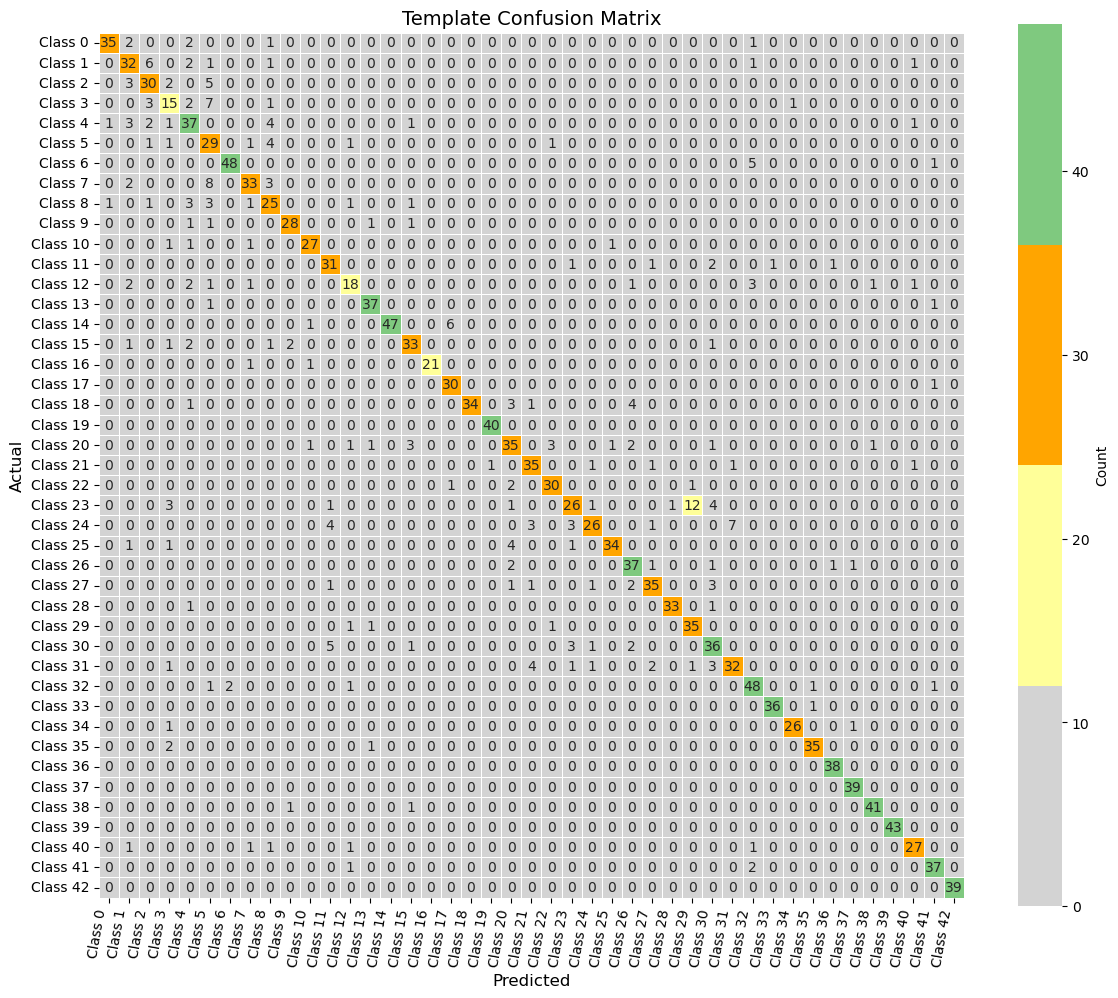

In [34]:
# Predict
print('Predicting ...')
y_pred = model_tem.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

plot_confusion_matrix('Template', y_test, y_prediction)

<HR>

### Combined Features (HOG, HUE, SAT, TEMPLATE, LBP)

In [52]:
# Derive dataset
columns = [
           'ClassId', 'Hue_Hist', 'Saturation_Hist', 'HOG_Features',
           'Template_Pattern', 'LBP_Image'
          ]

features_hue = features['Hue_Hist'].to_numpy()
features_hue = np.stack(features_hue)
features_sat = features['Saturation_Hist'].to_numpy()
features_sat = np.stack(features_sat)


renglones = features_hog.shape[0]
columnas = features_hog.shape[1] + features_tem.shape[1] + features_hue.shape[1] + features_sat.shape[1]
# features_combined = np.zeros(shape=(renglones, columnas))
features_combined = np.concatenate((features_hog, features_tem,
                                    features_hue, features_sat), axis=1)


# split the data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(features_combined, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)



In [53]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (6880, 6835)
y_train.shape: (6880,)
X_test.shape: (1720, 6835)
y_test.shape: (1720,)


In [54]:
model_com = create_cnn_model(input_shape=(X_train.shape[1], 1))


In [55]:
model_com.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['acc'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]

BATCH_SIZE = 32 
EPOCHS = 20

history = model_com.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 19s 104ms/step - loss: 3.7302 - acc: 0.0734 - val_loss: 3.3596 - val_acc: 0.0996
Epoch 2/20
172/172 [==============================] - 18s 104ms/step - loss: 3.0412 - acc: 0.1762 - val_loss: 2.9283 - val_acc: 0.2224
Epoch 3/20
172/172 [==============================] - 18s 106ms/step - loss: 2.2840 - acc: 0.3445 - val_loss: 2.0764 - val_acc: 0.4331
Epoch 4/20
172/172 [==============================] - 19s 111ms/step - loss: 1.6300 - acc: 0.4942 - val_loss: 1.2199 - val_acc: 0.6025
Epoch 5/20
172/172 [==============================] - 21s 124ms/step - loss: 1.0403 - acc: 0.6395 - val_loss: 0.6914 - val_acc: 0.7718
Epoch 6/20
172/172 [==============================] - 19s 111ms/step - loss: 0.6267 - acc: 0.7753 - val_loss: 0.4707 - val_acc: 0.8474
Epoch 7/20
172/172 [==============================] - 21s 124ms/step - loss: 0.4366 - acc: 0.8463 - val_loss: 0.3383 - val_acc: 0.8924
Epoch 8/20
172/172 [==============================] - 2

In [56]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_com.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


Evaluate on test data
54/54 [==============================] - 1s 14ms/step - loss: 0.3471 - acc: 0.9308
test loss, test acc: [0.3471269905567169, 0.9308139681816101]


Predicting ...
54/54 [==============================] - 1s 14ms/step

Accuracy on Test Set: 93.08139534883722


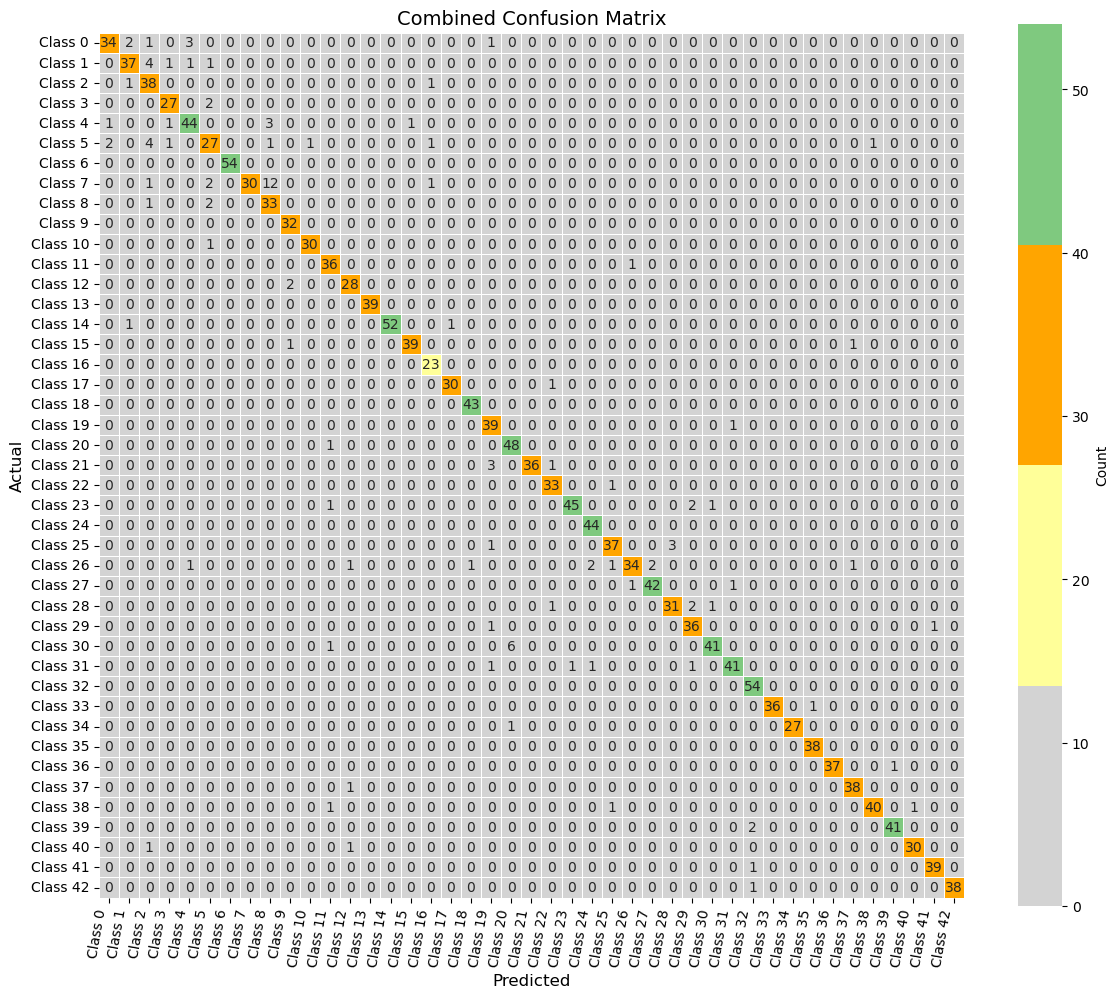

In [57]:
# Predict
print('Predicting ...')
y_pred = model_com.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

plot_confusion_matrix('Combined', y_test, y_prediction)

<HR>

In [ ]:
features_lbp = features['LBP_Hist'].to_numpy()
features_lbp = np.stack(features_lbp)
features_lbp.shape

# split the data into train, validation and test
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(features_lbp, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)

# normalize the data
X_train_lbp = X_train_lbp / 255
X_test_lbp = X_test_lbp / 255

features_hue = features['Hue_Hist'].to_numpy()
features_hue = np.stack(features_hue)
features_hue.shape

# split the data into train, validation and test
X_train_hue, X_test_hue, y_train_hue, y_test_hue = train_test_split(features_hue, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)

# normalize the data
X_train_hue = X_train_hue / 255
X_test_hue = X_test_hue / 255

# create files for saturation
features_sat = features['Saturation_Hist'].to_numpy()
features_sat = np.stack(features_sat)

# split the data into train, validation and test
X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(features_sat, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)

# normalize the data
# X_train_sat = X_train_sat / 255
# X_test_sat = X_test_sat / 255


In [ ]:
#apply CNN to LBP features
model_lbp = create_cnn_model(input_shape=ms_input_shape_lbp)
model_lbp.summary()


In [ ]:
#compile the model
model_lbp.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

#train the model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]

BATCH_SIZE = 32
EPOCHS = 20

history_2 = model_lbp.fit(X_train_lbp,
                    y_train_lbp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)





In [ ]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_lbp = model_lbp.evaluate(X_test_lbp, y_test_lbp, batch_size=32)
print("LBP test loss, LBP test acc:", results_lbp)

In [ ]:
# compile the model
model_hue = create_cnn_model(input_shape=ms_input_shape_hue)
model_hue.summary()

model_hue.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

#train the model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]   

BATCH_SIZE = 32
EPOCHS = 50

history_3 = model_hue.fit(X_train_hue,
                    y_train_hue,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)




In [ ]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hue = model_hue.evaluate(X_test_hue, y_test_hue, batch_size=32)
print("HUE test loss, HUE test acc:", results_hue)


In [ ]:
# create model for saturation
model_sat = create_cnn_model(input_shape=ms_input_shape_sat)

model_sat.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

#train the model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]

BATCH_SIZE = 32
EPOCHS = 50

history_4 = model_sat.fit(X_train_sat,
                    y_train_sat,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

                
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_sat = model_sat.evaluate(X_test_sat, y_test_sat, batch_size=32)
print("SAT test loss, SAT test acc:", results_sat)


